In [10]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import xgboost as xgb
import optuna
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# loading the data
data = pd.read_csv('T_Bills.csv')

In [3]:
# cleaning the data
data.ffill(inplace=True)

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data.tail()

,91-day T-Bill Rate,182-day T-Bill Rate,364-day Rate
Date,,,
2025-02-24,0.244786,0.253874,0.272996
2025-03-03,0.207906,0.229851,0.226994
2025-03-10,0.177200,0.189700,0.199800
2025-03-17,0.158600,0.169300,0.189700
2025-03-24,0.157400,0.169300,0.188500


In [6]:
data.isna().sum()

91-day T-Bill Rate     0
182-day T-Bill Rate    0
364-day Rate           0
dtype: int64

In [7]:
data.rename(columns={'91-day T-Bill Rate': '3_months', '182-day T-Bill Rate': '6_months', '364-day Rate': '1_year'}, inplace=True)

In [8]:
data.head()

,3_months,6_months,1_year
Date,,,
2013-11-13,0.1935,0.1925,0.185
2013-11-20,0.1866,0.1911,0.180
2013-11-27,0.1890,0.1930,0.180
2013-12-02,0.1870,0.1910,0.180
2013-12-09,0.1870,0.1880,0.175


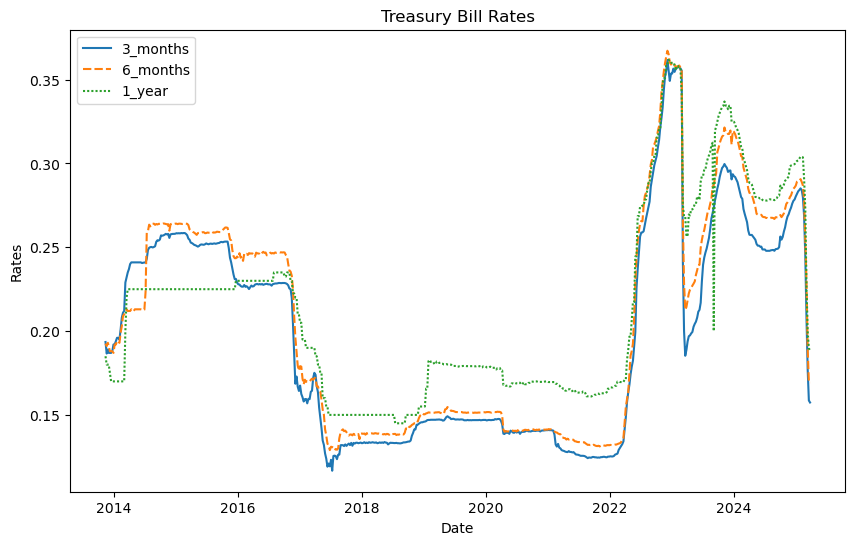

In [9]:
#plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=data)
plt.title('Treasury Bill Rates')
plt.xlabel('Date')
plt.ylabel('Rates')

plt.show()

### Volatility Modeling

In [19]:
# Rescale the target variable
data['3_months'] = data['3_months'] * 100
data['6_months'] = data['6_months'] * 100
data['1_year'] = data['1_year'] * 100


In [24]:
# Define search ranges for p, q
p = range(1, 4)
q = range(1, 4)

best_score, best_aic, best_bic, best_ll = float("inf"), float("inf"), float("inf"), -float("inf")
best_cfg = None

# Iterate over all combinations of (p, q)
for p, q in itertools.product(p, q):
    try:
        # Fit GARCH model without exogenous variables
        model = arch_model(data['3_months'], vol="Garch", p=p, q=q)
        results = model.fit(disp="off")

        # Evaluate model performance
        aic, bic, log_likelihood = results.aic, results.bic, results.loglikelihood
        predictions = results.forecast(horizon=3, reindex=False).variance.mean(axis=1)
        mse = mean_squared_error(data['3_months'][-3:], predictions)

        # Update best model criteria
        if mse < best_score:
            best_score, best_aic, best_bic, best_ll = mse, aic, bic, log_likelihood
            best_cfg = (p, q)
            print(f"New Best Model: GARCH({p}, {q}) -> MSE: {mse:.5f}, AIC: {aic:.2f}, BIC: {bic:.2f}, LL: {log_likelihood:.2f}")

    except Exception as e:
        continue  # Skip models that fail to converge

# Display final best model
if best_cfg is not None:
    print(f"\nBest GARCH Model: ({best_cfg[0]}, {best_cfg[1]}) with MSE: {best_score:.5f}, AIC: {best_aic:.2f}, BIC: {best_bic:.2f}, Log-Likelihood: {best_ll:.2f}")
else:
    print("\nNo valid GARCH model configuration was found.")


No valid GARCH model configuration was found.


In [ ]:
# Extract volatility from the best model
data["GARCH_Volatility"] = best_garch_result.conditional_volatility

In [ ]:
# Prepare dataset for XGBoost
X = data[["TBill_Lag1", "TBill_Lag2", "GARCH_Volatility"] + exog_vars]
y = data["TBill_Rate"]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Optimize XGBoost using Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


In [ ]:
# Train final XGBoost model with best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
xgb_model.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Final XGBoost Model RMSE: {rmse:.4f}")
print(f"Final XGBoost Model R² Score: {r2:.4f}")